### 3. Data Aquisition

#### D. Fire Scar

Data acquired on [NSW bushfire data archive](https://data.nsw.gov.au/data/dataset?q=text%3A%28fire%20OR%20GEEBAM%20OR%20%22NPWS%20Fire%20History%22%20OR%20%22bush%20fire%20prone%20land%22%29%20OR%20organization%3Answ-rural-fire-service), more specifically, this specific [link](https://data.nsw.gov.au/data/dataset/fire-history-wildfires-and-prescribed-burns-1e8b6).

This may be the most important information that we will get. If we are unable to differentiate events that happen spontaneously from the human provoked we will be training the model with wrong information (more noise to the model).

Let's look at the data and guarantee it can be used with precision.

Importing libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, box, Point, LineString, Polygon

%matplotlib inline

In [23]:
# Importing data
scar = gpd.read_file('./data/Firescar/Fire_NPWSFireHistory_2307220.shp')
scar.head()

,FireName,FireNo,Label,StartDate,EndDate,AreaHa,PerimeterM,geometry
0,None,None,1968-69 Prescribed Burn,1968-10-01,None,2.184770,1548.960666,"POLYGON ((153.14143 -30.17730, 153.14144 -30.1..."
1,None,None,1970-71 Prescribed Burn,None,None,299.985464,8615.637120,"POLYGON ((152.77796 -31.63806, 152.77822 -31.6..."
2,None,70/161,1970-71 Prescribed Burn,None,None,309.025645,20657.633993,"POLYGON ((151.50894 -31.98245, 151.50911 -31.9..."
3,None,None,1970-71 Prescribed Burn,1970-07-01,None,13.600002,1999.487701,"POLYGON ((153.14728 -30.17573, 153.14721 -30.1..."
4,None,0,1971-72 Prescribed Burn,1971-07-01,None,58.994371,5312.210152,"POLYGON ((152.21270 -32.24101, 152.21272 -32.2..."


In [3]:
scar.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34315 entries, 0 to 34314
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FireName    19665 non-null  object  
 1   FireNo      16761 non-null  object  
 2   Label       34315 non-null  object  
 3   StartDate   18424 non-null  object  
 4   EndDate     13573 non-null  object  
 5   AreaHa      34315 non-null  float64 
 6   PerimeterM  34315 non-null  float64 
 7   geometry    34315 non-null  geometry
dtypes: float64(2), geometry(1), object(5)
memory usage: 2.1+ MB


In [5]:
scar.describe().T

,count,mean,std,min,25%,50%,75%,max
AreaHa,34315.0,998.245999,23854.531538,3.000000e-08,2.589718,22.672652,160.177477,3.465373e+06
PerimeterM,34315.0,9175.230189,43261.435759,1.988490e-01,740.724247,2519.906642,7635.442500,3.172177e+06


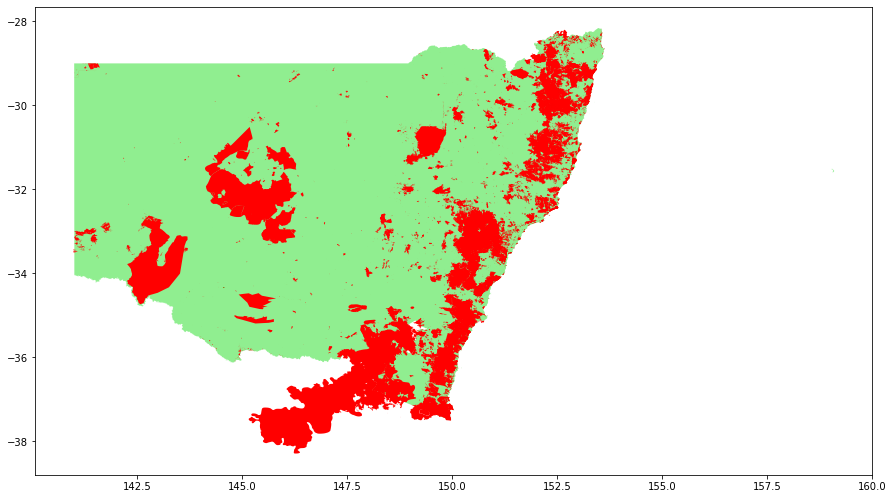

In [7]:
# Plotting to map to guarantee data robustness.
nsw = gpd.read_file('./data/map/NSW/state/NSW_STATE_POLYGON_shp.shp')

# Creating figure to plot
fig, ax = plt.subplots(figsize=(15,15))
# Plot the country borders
nsw.plot(ax=ax, color='LightGreen')
# Plot the individual points
scar['geometry'].plot(ax=ax, color='red',  markersize=10)


There is something weird happening here.

Part of the scars are bleeding out in to Victoria. lets try to understand what is going on before diving in to the dataset.

In [8]:
# checking the crs
scar.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Ok, just look at this:

- bounds: (93.41, -60.56, **173.35**, -8.47)

The bounds of the data make no sense. 

let's look at that specific polygon and restrict the begining of the bushfires to the dates we have the weather.

#### Checking the relaiability of the data
1. <a href='#Restricting_dates'>Retricting dates</a>
2. <a href='#checking'>Checking southernmost polygon</a>
3. <a href='#dividing'>Dividing the wildfires and prescribed burns</a>



<a id='Restricting_dates'></a>

#### 1. Retricting dates
Restricting dates between 01/11/2017 and 25/06/2017

In [24]:
#  making column names lowercase
scar.columns = [x.lower() for x in scar.columns]

In [25]:
scar.head()

,firename,fireno,label,startdate,enddate,areaha,perimeterm,geometry
0,None,None,1968-69 Prescribed Burn,1968-10-01,None,2.184770,1548.960666,"POLYGON ((153.14143 -30.17730, 153.14144 -30.1..."
1,None,None,1970-71 Prescribed Burn,None,None,299.985464,8615.637120,"POLYGON ((152.77796 -31.63806, 152.77822 -31.6..."
2,None,70/161,1970-71 Prescribed Burn,None,None,309.025645,20657.633993,"POLYGON ((151.50894 -31.98245, 151.50911 -31.9..."
3,None,None,1970-71 Prescribed Burn,1970-07-01,None,13.600002,1999.487701,"POLYGON ((153.14728 -30.17573, 153.14721 -30.1..."
4,None,0,1971-72 Prescribed Burn,1971-07-01,None,58.994371,5312.210152,"POLYGON ((152.21270 -32.24101, 152.21272 -32.2..."


In [13]:
scar.label.value_counts()

2002-03 Wildfire           1326
2019-20 Wildfire            812
2001-02 Wildfire            773
1991-92 Wildfire            711
2009-10 Wildfire            689
                           ... 
1926-27 Wildfire              1
1969-70 Prescribed Burn       1
1961-62 Prescribed Burn       1
1939-40 Wildfire              1
1960-61 Prescribed Burn       1
Name: label, Length: 145, dtype: int64

In [26]:
# Getting a date column
scar['date'] = pd.to_datetime(scar['startdate'])
# restricting only to the dates we have events
scar_date = scar[(scar['date'] >= '2007/11/01') & (scar['date'] <= '2017/06/25') ]

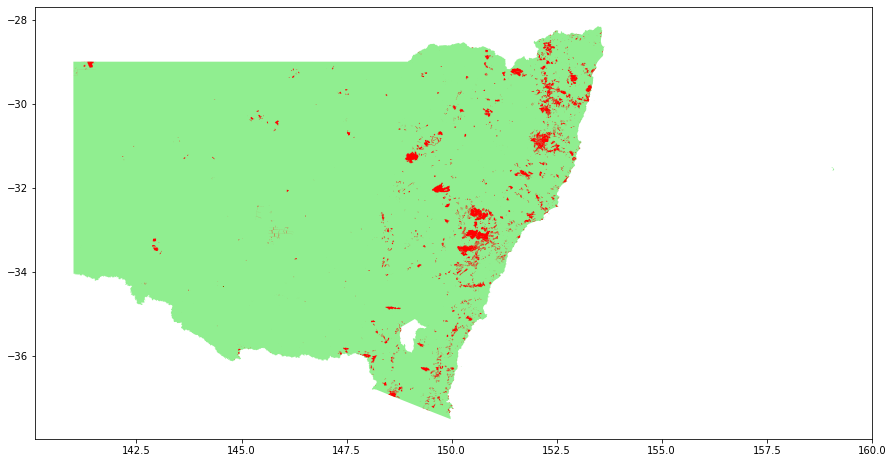

In [30]:
# Plotting to map to guarantee data robustness.
nsw = gpd.read_file('./data/map/NSW/state/NSW_STATE_POLYGON_shp.shp')

# Creating figure to plot
fig, ax = plt.subplots(figsize=(15,15))
# Plot the country borders
nsw.plot(ax=ax, color='LightGreen')
# Plot the individual points
scar_date['geometry'].plot(ax=ax, color='red',  markersize=10)

There are very few entries here. There are much more events happening than what is presented on this polygons, man made or otherwise.

This may be explained by some entries not having a registered date, but we will not be able to use the data if it has no temporal information anyway.

<a id='checking'></a>

#### 2. Checking southernmost polygon
This points should not be considered. They may be spills from fires that start in NSW, but we will not be sure until we look at it.

The off-coas fires may also be island fires.

In [29]:
scar_date.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
scar_date.shape

(6079, 9)

In [34]:
scar_date.startdate.min()

'2007-11-02'